In [1]:
import sys
sys.path.append('../')
import mobipy
import mobipy.optim as opt
import mobipy.stats as stat
import numpy as np
import matplotlib.pyplot as plt

import corner

## Note
This notebook will be better documented once the API has stabilized.

In [2]:
modfile = mobipy.mobius2_path() + 'models/simplyq_model.txt'
datfile = mobipy.mobius2_path() + 'models/data/simplyq_simple.dat'
app = mobipy.Model_Application.build_from_model_and_data_file(modfile, datfile, store_all_series=True) 

app.start_date = '2004-01-01'
app.end_date = '2005-12-31'

optim_start ='2004-03-01'
optim_end = '2005-12-31'

sl = slice(app.start_date[()], app.end_date[()])

app.run()

True

In [3]:
par_dict = {
    'bfi' : ("SimplyQ land", "bfi", [], 0, 1),
    'tc_s' : ("SimplyQ land", "tc_s", ["One"], 1, 15),
    'tc_g' : ("SimplyQ land", "tc_g", [], 100, 400),
    'qqinfl' : ("SimplyQ land", "qqinfl", [], 100, 1000),
    'ddf_pet' : ("Degree-day PET", "ddf_pet", [], 0.05, 0.25),
    'pet_min_t' : ("Degree-day PET", "pet_min_t", [], -4, 4),
    'ddf_melt' : ("HBVSnow", "ddf_melt", [], 1, 6)
}

params, set_params = opt.params_from_dict(app, par_dict)
opt.add_wls_params(params, 
                   0.01, 0, 0.05,
                   0.5, 0.01, 1.5)

params.pretty_print()

Name          Value      Min      Max   Stderr     Vary     Expr Brute_Step
__mu           0.01        0     0.05     None     True     None     None
__sigma         0.5     0.01      1.5     None     True     None     None
bfi             0.6        0        1     None     True     None     None
ddf_melt          4        1        6     None     True     None     None
ddf_pet        0.16     0.05     0.25     None     True     None     None
pet_min_t         0       -4        4     None     True     None     None
qqinfl          400      100     1000     None     True     None     None
tc_g            200      100      400     None     True     None     None
tc_s              8        1       15     None     True     None     None


In [4]:
target = ("Reach flow", "Coull", "Observed Q", ())

get_sim_obs    = opt.residual_from_target(target, optim_start, optim_end)
log_likelihood = opt.ll_from_target(target, optim_start, optim_end)

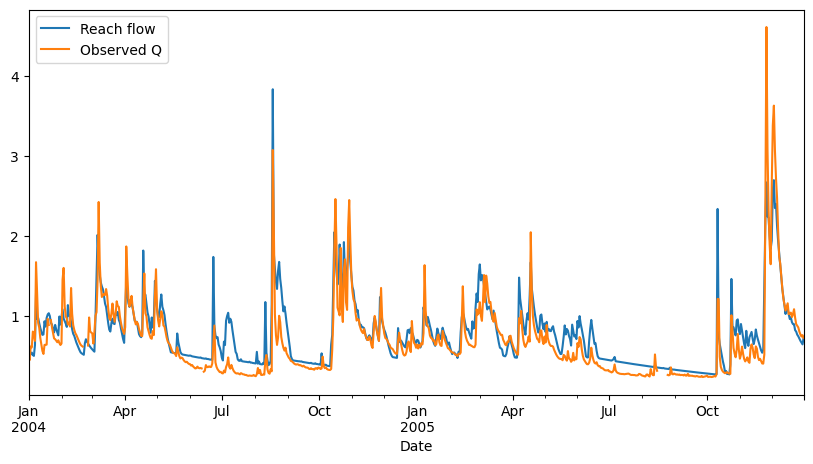

In [5]:
#TODO: Make a plot_target function
fig, ax = plt.subplots(1, figsize=(10, 5))

app.var('Reach flow')['Coull'].loc[sl].plot(ax=ax)
app.var('Observed Q')[()].loc[sl].plot(ax=ax)
ax.legend()

In [6]:
sim, obs = get_sim_obs(app)
ns_before = stat.nash_sutcliffe(sim, obs)
kg_before = stat.kling_gupta(sim, obs)

res_opt = opt.run_minimizer(app, params, set_params, get_sim_obs)

set_params(app, res_opt.params)
app.run()

sim, obs = get_sim_obs(app)
ns_after = stat.nash_sutcliffe(sim, obs)
kg_after = stat.kling_gupta(sim, obs)

print("Nash-Sutcliffe efficiency: before: %g, after %g" % (ns_before, ns_after))
print("Kling-Gupta efficiency: before: %g, after %g" % (kg_before, kg_after))

Nash-Sutcliffe efficiency: before: 0.754792, after 0.846105
Kling-Gupta efficiency: before: 0.783179, after 0.891467


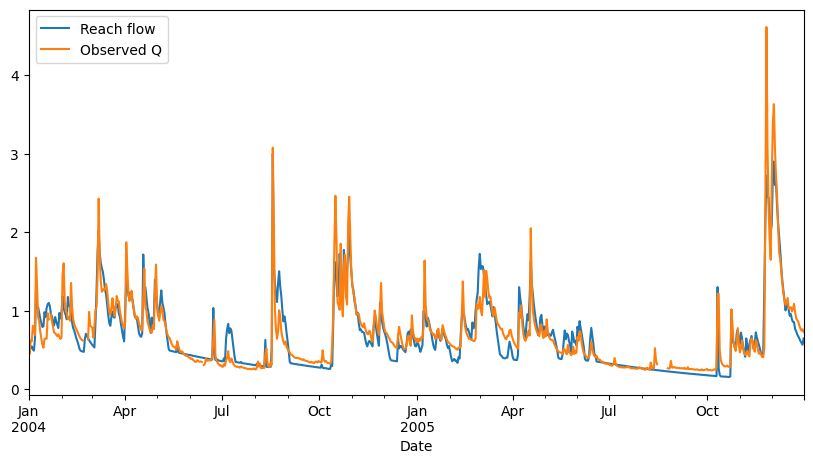

In [7]:
fig, ax = plt.subplots(1, figsize=(10, 5))

app.var('Reach flow')['Coull'].loc[sl].plot(ax=ax)
app.var('Observed Q')[()].loc[sl].plot(ax=ax)
ax.legend()

In [8]:
# In practice it should be run with something like 15000 steps
res = opt.run_mcmc(app, res_opt.params, set_params, log_likelihood, burn=500, steps=4000, walkers=50)

100%|██████████████████████████████████████████████████████████████████████████████| 4000/4000 [11:50<00:00,  5.63it/s]

The chain is shorter than 50 times the integrated autocorrelation time for 9 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 80;
tau: [461.21031499 442.78622394 450.28882217 418.37281644 421.97974453
 449.28970227 449.27597454 419.72627441 443.72761314]


Quantiles:
[(0.025, np.float64(0.40229350648501216)), (0.5, np.float64(0.5501198917008335)), (0.975, np.float64(0.691793950525957))]
Quantiles:
[(0.025, np.float64(7.305053525838858)), (0.5, np.float64(7.981833322883709)), (0.975, np.float64(8.167850144595711))]
Quantiles:
[(0.025, np.float64(151.964003284702)), (0.5, np.float64(152.14378064265688)), (0.975, np.float64(152.62101460128414))]
Quantiles:
[(0.025, np.float64(579.9547778578789)), (0.5, np.float64(580.1402465813072)), (0.975, np.float64(580.4090017897844))]
Quantiles:
[(0.025, np.float64(0.10023479601698544)), (0.5, np.float64(0.19582152381240084)), (0.975, np.float64(0.2382137096052308))]
Quantiles:
[(0.025, np.float64(-0.3404515260573435)), (0.5, np.float64(-0.014184211578263821)), (0.975, np.float64(0.2484037227093408))]
Quantiles:
[(0.025, np.float64(2.8259263424803236)), (0.5, np.float64(3.1117603619780887)), (0.975, np.float64(3.1657952904090734))]
Quantiles:
[(0.025, np.float64(0.00020248603722345)), (0.5, np.float64(

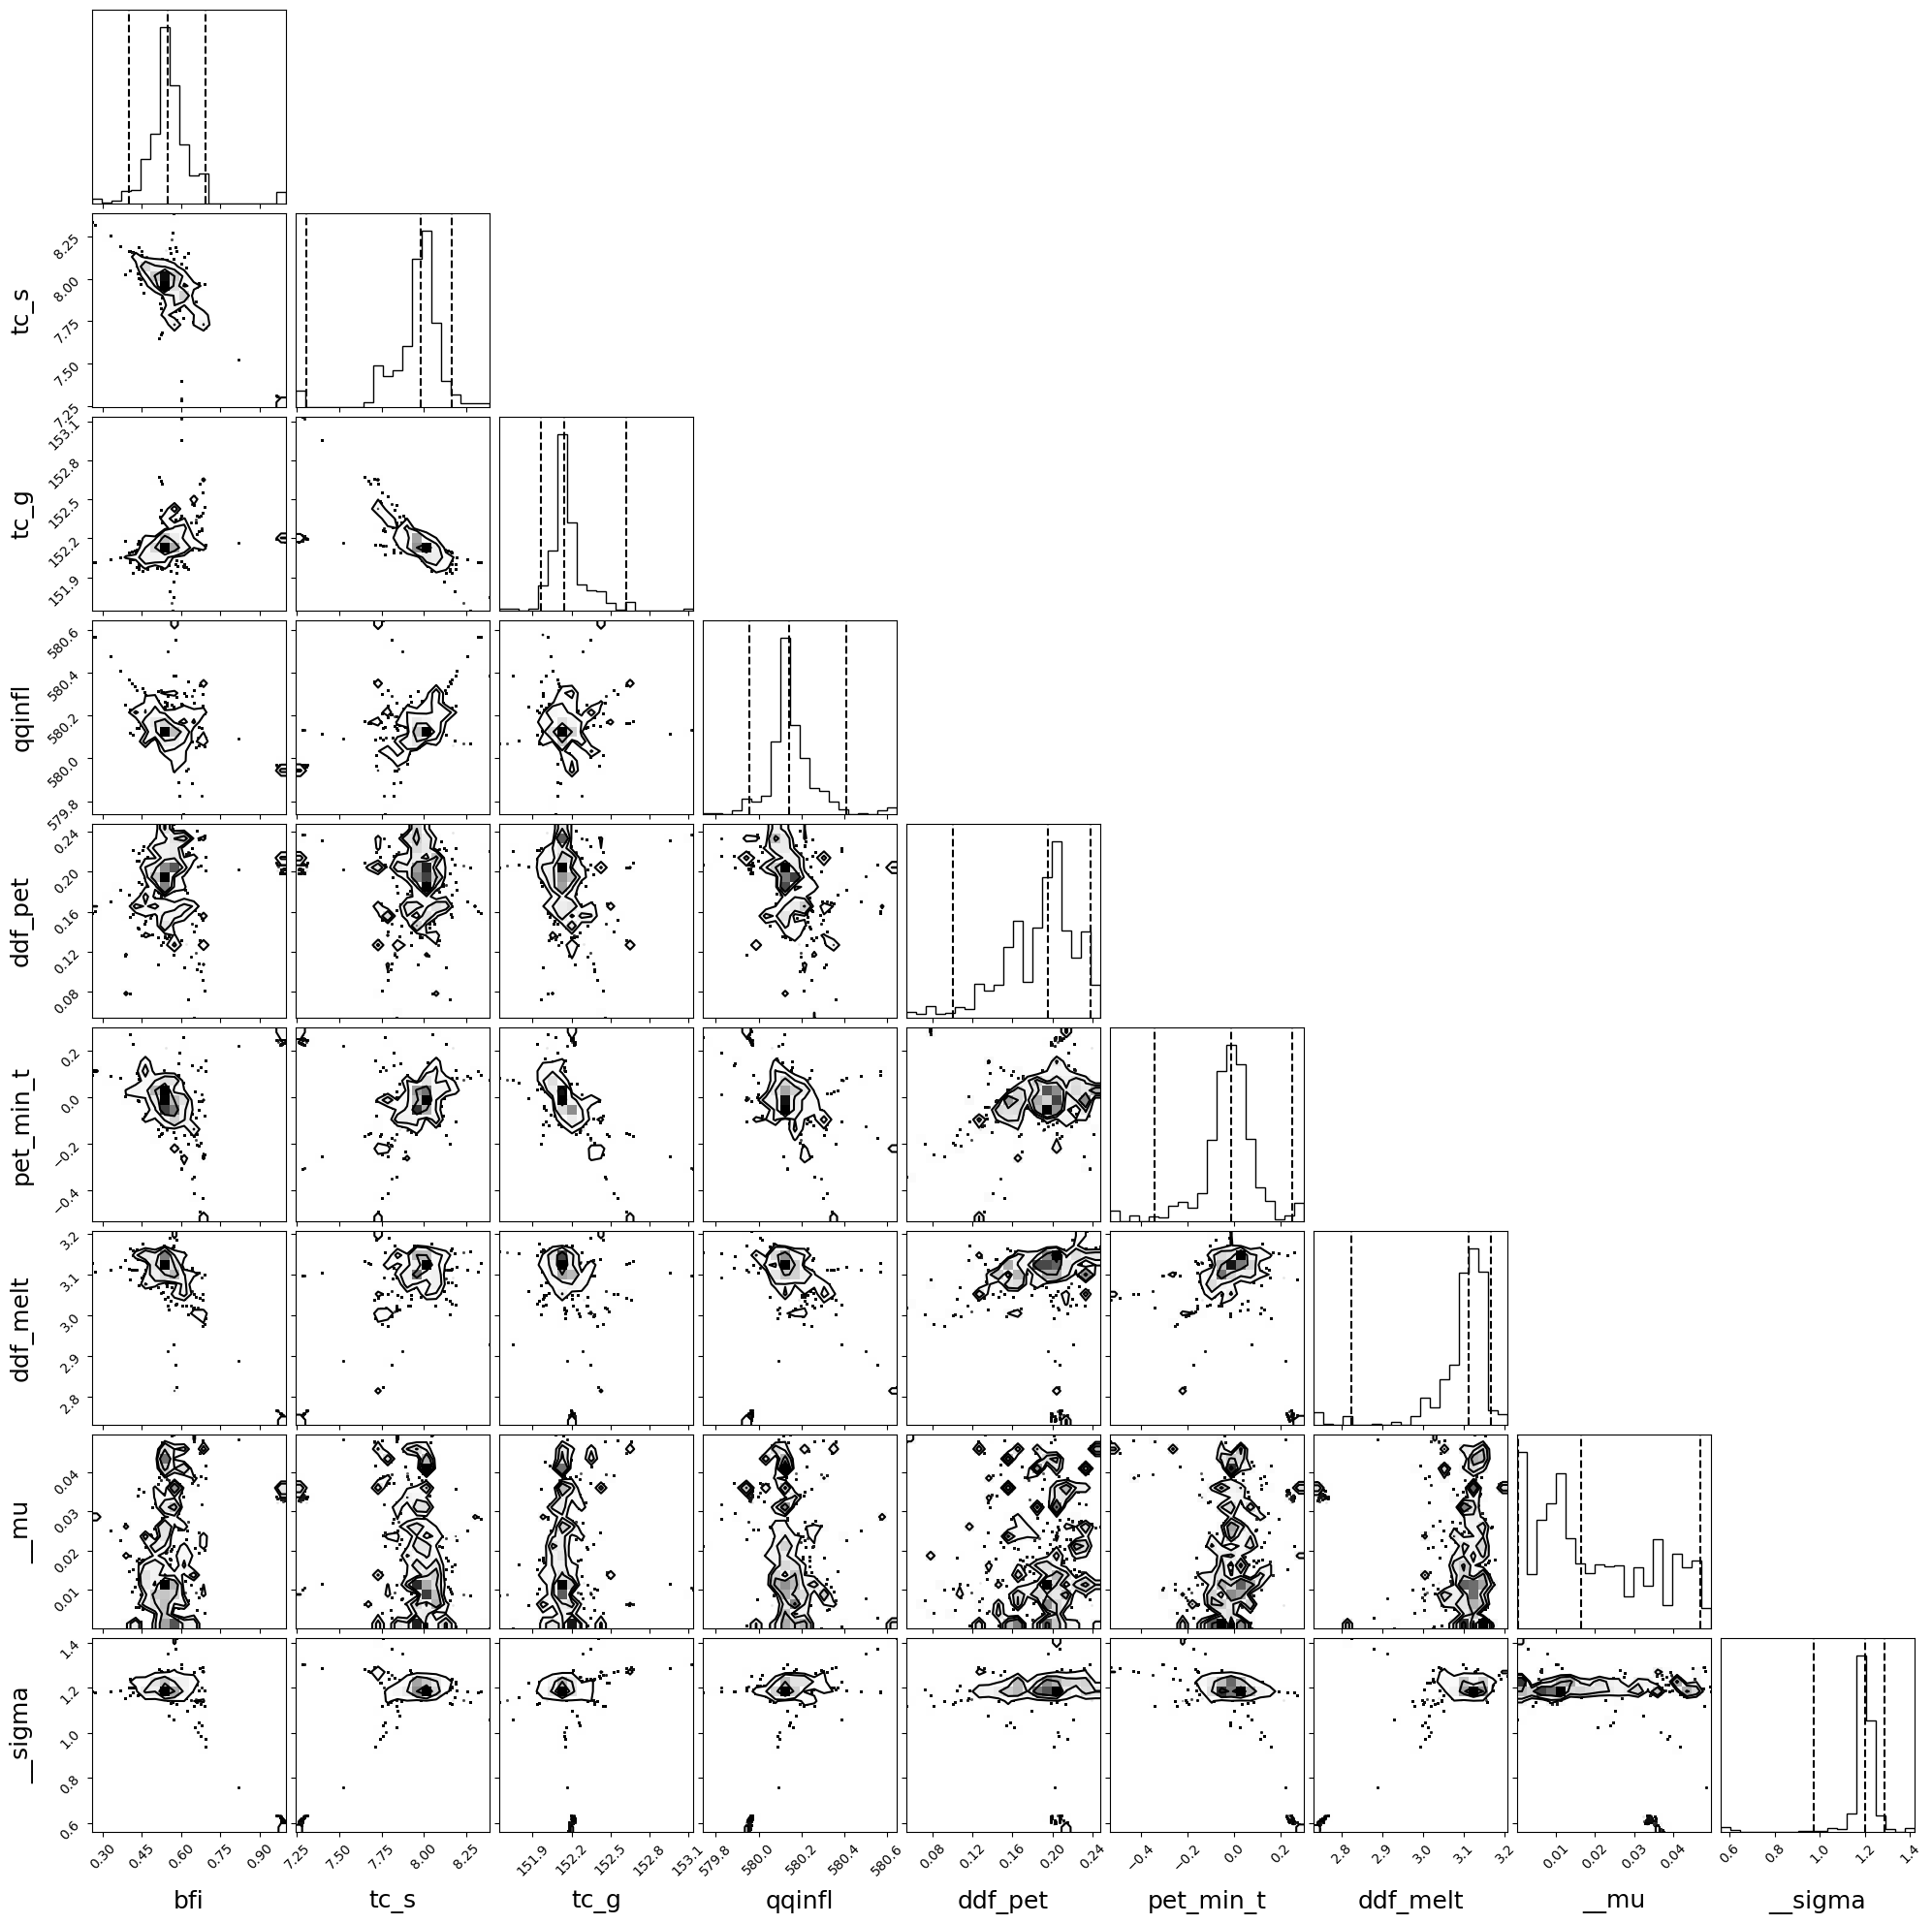

In [9]:
# TODO: Seems like we need to manually remove the burnin here?

c = corner.corner(res.flatchain, 
              labels=res.var_names, 
              title_args={'fontsize':20},
              label_kwargs={'fontsize':18},
              verbose=True,
              quantiles=[0.025, 0.5, 0.975]
             )

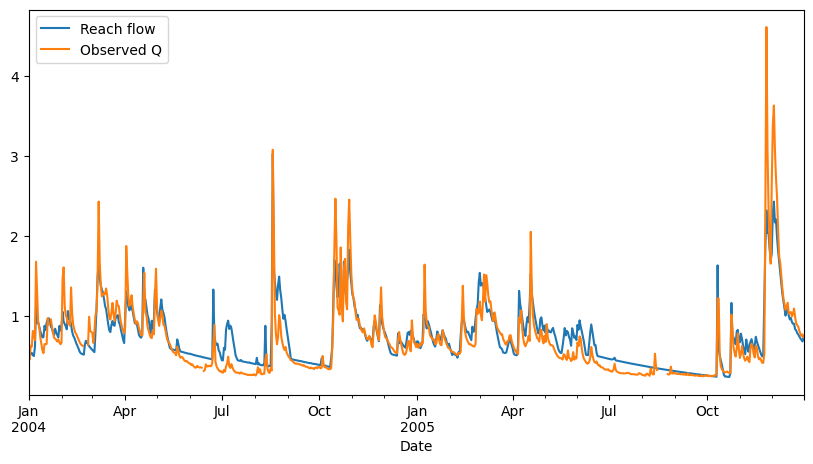

In [10]:
# Extract max likelihood params
highest_prob = np.argmax(res.lnprob)
hp_loc = np.unravel_index(highest_prob, res.lnprob.shape)
mle_soln = res.chain[hp_loc]

for i, par_name in enumerate(params):
    params[par_name].value = mle_soln[i]
set_params(app, params)

# Run and plot result with these params
app.run()

fig, ax = plt.subplots(1, figsize=(10, 5))

sl = slice(app.start_date[()], app.end_date[()])

app.var('Reach flow')['Coull'].loc[sl].plot(ax=ax)
app.var('Observed Q')[()].loc[sl].plot(ax=ax)
ax.legend()